# Team 2 - Rosana Valero Martínez, Marcos Muñoz González and Abel García
## Week 2

In [176]:
import cv2
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import sys
import warnings
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import seaborn as sns
import os
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, PowerTransformer, Normalizer
import scikitplot as skplt

warnings.filterwarnings('ignore')
%matplotlib inline

Let us first read the train and test files

In [33]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_images_filenames = [n[16:] for n in train_images_filenames]
test_images_filenames  = [n[16:] for n in test_images_filenames]
train_labels = pickle.load(open('train_labels.dat','rb')) 
test_labels = pickle.load(open('test_labels.dat','rb'))

In [34]:
train_images_filenames[12]

'MIT_split/train/Opencountry/fie26.jpg'

In [35]:
images_filenames = train_images_filenames
images_filenames.extend(test_images_filenames)
labels = train_labels
labels.extend(test_labels)

X = np.zeros((len(labels), 2), dtype='object')
X[:, 0] = images_filenames
X[:, 1] = labels

X.shape

(2688, 2)

# Different classes that will be used across the notebook

We create a BoVW class which will handle all the things related to our bag of visual words algorithm such as the method used for classification, which detector to use, etc. and an Experiment class which will help us to measure the performance of the algorithm. Additionally, we save in storage the different outputs given by the detector and the initial classifier in order to avoid computation time

In [230]:
class BoVW:
  def __init__(self, train_index, test_index, n_splits, split, detector_data={'name':'sift', 'detector': cv2.SIFT_create()}, metric='euclidean', 
               method='kmeans', classification_method={'name':'knn'}, k=260, n=5, normalization='normalizer', spatial_pyramids = {'n_squares':[1,2], 'n_weights':[1/2,1/2]},
               dimensionality_reduction={'name':'PCA','n_components':32}, random_state=42, checkpoint_folder='./checkpoints/', visualization=False):
    # Get file data  
    self.train_images_filenames = X[train_index, 0]
    self.test_images_filenames  = X[test_index, 0]
    
    self.train_labels = X[train_index, 1]
    self.test_labels = X[test_index, 1]
    self.detector_data = detector_data
    self.metric = metric
    self.k = k
    self.n = n
    self.dimensionality_reduction = dimensionality_reduction
    self.random_state = random_state
    self.n_splits = n_splits
    self.split = split
    self.method = method
    self.spatial_pyramids = spatial_pyramids
    self.classification_method = classification_method
    self.checkpoint_filename = checkpoint_folder + str(self.n_splits) + '_' + str(self.split) + '_'
    self.normalization = normalization
    self.visualization = visualization
  
  
  def normalize(self, train, test, is_list = True):
    if is_list == True:
      old_train_shape = np.array(train).shape
      old_test_shape = np.array(test).shape
      
      train = np.vstack(np.array(train))
      test = np.vstack(np.array(test))
    
    if self.normalization is not None:
      if self.normalization == 'standardscaler':
        transformer = StandardScaler().fit(train)
        train = transformer.transform(train)
        test = transformer.transform(test)
      elif self.normalization == 'powertransformer':
        transformer = PowerTransformer(method='yeo-johnson', standardize=True).fit(train)
        train = transformer.transform(train)
        test = transformer.transform(test)
      elif self.normalization == 'normalizer':
        transformer = Normalizer().fit(train)
        train = transformer.transform(train)
        test = transformer.transform(test)
        
    if is_list == True:
      train = train.reshape(old_train_shape)
      test = test.reshape(old_test_shape)
      train, test = train.tolist(), test.tolist()
    
    return train, test
  
  def run(self):
    # Load or save feature descriptors as needed    
    checkpoint_key_detector_data = ''
    for key, value in self.detector_data.items():
      if isinstance(value, str):
        checkpoint_key_detector_data += key + '_' + value
      elif isinstance(value, int):
        checkpoint_key_detector_data += key + '_' + str(value)
        
    checkpoint_key_detector_data = self.checkpoint_filename+checkpoint_key_detector_data
    
    if self.normalization is not None:
      checkpoint_key_detector_data += '_' + self.normalization
    
    
    if self.visualization == True:
      fig = plt.figure(figsize=(15, 6))
      fig.suptitle('Keypoints of images computed with ' + self.detector_data['name'].capitalize(), fontsize=20)
      num_cols = 5
      num_rows = 2
      index_visual = 0
      for i in range(num_rows):
        for j in range(num_cols):
          index_visual += 1
          plt.subplot(num_rows, num_cols, index_visual)
          plt.axis('off')
          index = np.random.random_integers(0, len(self.train_images_filenames))
          plt.imshow(self.get_img_keypoints(cv2.imread(self.train_images_filenames[index]), self.detector_data))
      plt.show()
    
    if os.path.isfile(checkpoint_key_detector_data+'.pickle') == False:
      self.get_descriptors()
      
      if self.normalization is not None:
        self.train_descriptors, self.test_descriptors = self.normalize(self.train_descriptors, self.test_descriptors)   
                
      with open(checkpoint_key_detector_data+'.pickle', 'wb') as handle:
          pickle.dump({'train_descriptors': self.train_descriptors, 'test_descriptors': self.test_descriptors}, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
      with open(checkpoint_key_detector_data+'.pickle', 'rb') as handle:
          tmp = pickle.load(handle)
          self.train_descriptors = tmp['train_descriptors']
          self.test_descriptors = tmp['test_descriptors']
    
    if self.method == 'kmeans':
      # Load or save codebook data as needed
      checkpoint_key_kmeans = checkpoint_key_detector_data + '_kmeans_' + str(self.k)
      
      if os.path.isfile(checkpoint_key_kmeans+'.pickle') == False:
        self.compute_kmeans()
        with open(checkpoint_key_kmeans+'.pickle', 'wb') as handle:
            pickle.dump({'train_visual_words': self.train_visual_words, 'test_visual_words': self.test_visual_words, 'codebook': self.codebook},
                        handle, protocol=pickle.HIGHEST_PROTOCOL)
      else:
        with open(checkpoint_key_kmeans+'.pickle', 'rb') as handle:
            tmp = pickle.load(handle)
            self.train_visual_words = tmp['train_visual_words']
            self.test_visual_words = tmp['test_visual_words']
            self.codebook = tmp['codebook']
    elif self.method == 'gmm':
      checkpoint_key_gmm = checkpoint_key_detector_data + '_gmm_' + str(self.k)
      
      if os.path.isfile(checkpoint_key_gmm+'.pickle') == False:
        gmm = GaussianMixture(n_components=self.k, n_init=1)
        gmm.fit(np.vstack(self.train_descriptors))
        gmm_train = gmm.predict(np.vstack(self.train_descriptors))
        gmm_test = gmm.predict(np.vstack(self.test_descriptors))
        gmm_weights = gmm.weights_
        gmm_means = gmm.means_
        gmm_covariances = gmm.covariances_
        with open(checkpoint_key_gmm+'.pickle', 'wb') as handle:
            pickle.dump({'gmm_train': gmm_train, 'gmm_test': gmm_test, 'gmm_weights': gmm_weights, 'gmm_means': gmm_means, 'gmm_covariances': gmm_covariances},
                        handle, protocol=pickle.HIGHEST_PROTOCOL)
      else:
        with open(checkpoint_key_gmm+'.pickle', 'rb') as handle:
            tmp = pickle.load(handle)
            gmm_train = tmp['gmm_train']
            gmm_test = tmp['gmm_test']
            gmm_weights = tmp['gmm_weights']
            gmm_means = tmp['gmm_means']
            gmm_covariances = tmp['gmm_covariances']
            
    if self.spatial_pyramids is not None:
      if self.visualization == True:
        self.show_spatial_pyramid_keypoints(cv2.imread(self.train_images_filenames[np.random.random_integers(0, len(self.train_images_filenames))]),
                                            self.spatial_pyramids['n_squares'])
              
      checkpoint_key_pyramids = checkpoint_key_kmeans + '_' + 'spatial_pyramid' + '_' + '_'.join([str(n) for n in self.spatial_pyramids['n_squares']]) \
        + '_' + '_'.join([str(int(n * 100)) for n in self.spatial_pyramids['n_weights']])
        
      if os.path.isfile(checkpoint_key_pyramids+'.pickle') == False:
        self.get_spatial_pyramid(self.spatial_pyramids['n_squares'], self.spatial_pyramids['n_weights'])
        with open(checkpoint_key_pyramids+'.pickle', 'wb') as handle:
            pickle.dump({'train_visual_words': self.train_visual_words, 'test_visual_words': self.test_visual_words},
                        handle, protocol=pickle.HIGHEST_PROTOCOL)
      else:
        with open(checkpoint_key_pyramids+'.pickle', 'rb') as handle:
            tmp = pickle.load(handle)
            self.train_visual_words = tmp['train_visual_words']
            self.test_visual_words = tmp['test_visual_words']
      
    
    
    # If dimensionality reduction is needed
    if self.dimensionality_reduction != None:
      self.reduce_dimensionality()
      
    if self.classification_method['name'] == 'knn':
      self.compute_knn()
    elif self.classification_method['name'] == 'svm':
      self.compute_svm()
    
    return self.accuracy, self.precision, self.recall, self.fscore
  
  def show_spatial_pyramid_keypoints(self, img, n_squares):
    height, width, _ = img.shape
    
    img_keypoints_orig = self.get_img_keypoints(img, self.detector_data)
    
    pyramid = []
    for n in n_squares:
      square_height = height // n
      square_width = width // n

      result = np.zeros((height, width, 3), np.uint8)
      
      img_keypoints = img_keypoints_orig.copy()
      for row in range(n):
          for col in range(n):
              # Crop square from image
              x1 = col * square_width
              y1 = row * square_height
              x2 = x1 + square_width
              y2 = y1 + square_height
              square = img_keypoints[y1:y2, x1:x2]
                
              result[y1:y2, x1:x2] = square
              cv2.rectangle(img_keypoints, (x1,y1), (x2,y2), (255,255,255), 2)
      pyramid.append(result)
    
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle('Spatial pyramid divisions with keypoints', fontsize=20)
    n_cols = len(n_squares)
    for i in range(n_cols):
      plt.subplot(1, n_cols, i+1)
      plt.axis('off')
      plt.imshow(pyramid[i])
    plt.show()
  
  def get_pyramid_histograms(self, ima, n_squares, n_weights):
    height, width, _ = ima.shape
    histograms = []
    
    i = 0

    for n in n_squares:
        square_height = height // n
        square_width = width // n

        result = np.zeros((height, width, 3), np.uint8)

        for row in range(n):
            for col in range(n):
                # Crop square from image
                x1 = col * square_width
                y1 = row * square_height
                x2 = x1 + square_width
                y2 = y1 + square_height
                square = ima[y1:y2, x1:x2]          
                
                result[y1:y2, x1:x2] = square
                des = self.compute_descriptor(square, self.detector_data)
                
                if des is not None:                  
                  words = self.codebook.predict(des)
                  histogram = np.bincount(words,minlength=self.k)
                else:
                  histogram = np.zeros(self.k)
                
                histogram = [n_weights[i]*elem for elem in histogram]
                histograms.append(histogram)
        
        i += 1
    
    histograms=np.array(histograms)
    
    histograms=histograms.flatten()
    
    return histograms
  
  def get_spatial_pyramid(self, n_squares=[1,2], n_weights=[1/2,1/2]):
    len_histograms = 0
    for i in n_squares:
        len_histograms += self.k*(i**2)
    
    train_visual_words=np.zeros((len(self.train_descriptors),len_histograms),dtype=np.float32)
    test_visual_words=np.zeros((len(self.test_descriptors),len_histograms),dtype=np.float32)
    
    for i, filename in enumerate(self.train_images_filenames):
      train_visual_words[i,:] = self.get_pyramid_histograms(cv2.imread(filename), n_squares, n_weights)
    
    for i, filename in enumerate(self.test_images_filenames):
      test_visual_words[i,:] = self.get_pyramid_histograms(cv2.imread(filename), n_squares, n_weights)
      
      
    self.train_visual_words = train_visual_words
    self.test_visual_words = test_visual_words
      
  def get_img_keypoints(self, img, detector_data):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    if detector_data['name'] == 'dense_sift':
      keypoints = []
      for y in range(0, gray.shape[0], detector_data['step_size']):
          for x in range(0, gray.shape[1], detector_data['step_size']):
              keypoints.append(cv2.KeyPoint(x, y, detector_data['step_size']))

      
      _, des = detector_data['detector'].compute(gray, keypoints)
    else:
      keypoints, des = detector_data['detector'].detectAndCompute(gray,None)
      
    img_keypoints = cv2.drawKeypoints(gray, keypoints, img)
    
    return img_keypoints
  
  def compute_descriptor(self, img, detector_data):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    if detector_data['name'] == 'dense_sift':
      keypoints = []
      for y in range(0, gray.shape[0], detector_data['step_size']):
          for x in range(0, gray.shape[1], detector_data['step_size']):
              keypoints.append(cv2.KeyPoint(x, y, detector_data['step_size']))

      
      _, des = detector_data['detector'].compute(gray, keypoints)
    else:
      _, des = detector_data['detector'].detectAndCompute(gray,None)
      
    return des
  
  def get_square_descriptors(self, img, n):
    height, width, _  = img.shape
    square_height = height // n
    square_width = width // n

    result = np.zeros((height, width, 3), np.uint8)
    img_descriptors = []
    
    for row in range(n):
        for col in range(n):
          x1 = col * square_width
          y1 = row * square_height
          x2 = x1 + square_width
          y2 = y1 + square_height
          square = img[y1:y2, x1:x2]
          des = self.compute_descriptor(square, self.detector_data)
          img_descriptors.append(des)
          
    return img_descriptors
  
  def get_descriptors(self):    
    train_descriptors = []
    test_descriptors = []
    
    
    for filename in self.train_images_filenames:
      train_descriptors.append(self.compute_descriptor(cv2.imread(filename), self.detector_data))
      
    for filename in self.test_images_filenames:
      test_descriptors.append(self.compute_descriptor(cv2.imread(filename), self.detector_data))
      
    self.train_descriptors = train_descriptors
    self.test_descriptors = test_descriptors
    
  def compute_kmeans(self):
    codebook = MiniBatchKMeans(n_clusters=self.k, verbose=False, batch_size=self.k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=self.random_state)
    codebook.fit(np.vstack(self.train_descriptors))

    train_visual_words=np.zeros((len(self.train_descriptors),self.k),dtype=np.float32)
    for i in range(len(self.train_descriptors)):
        words=codebook.predict(self.train_descriptors[i])
        train_visual_words[i,:]=np.bincount(words,minlength=self.k)
        
    test_visual_words=np.zeros((len(self.test_descriptors),self.k),dtype=np.float32)
    for i in range(len(self.test_descriptors)):
        words = codebook.predict(self.test_descriptors[i])
        test_visual_words[i,:]=np.bincount(words,minlength=self.k)
    
    self.codebook = codebook
    self.train_visual_words = train_visual_words
    self.test_visual_words = test_visual_words
    
  def reduce_dimensionality(self):
    if self.dimensionality_reduction['name'] == 'PCA':
      pca = PCA(n_components = self.dimensionality_reduction['n_components'], random_state=self.random_state)
      
      self.train_visual_words = pca.fit_transform(self.train_visual_words)
      self.test_visual_words = pca.transform(self.test_visual_words)
    elif self.dimensionality_reduction['name'] == 'LDA':
      lda = LinearDiscriminantAnalysis(n_components=self.dimensionality_reduction['n_components'], random_state=self.random_state)
      self.train_visual_words = lda.fit_transform(self.train_visual_words, self.train_labels)
      self.test_visual_words = lda.transform(self.test_visual_words)
 
  def histogramIntersection(self, M, N):
    K = np.zeros((M.shape[0], N.shape[0]), dtype=float)

    for j, _ in enumerate(N):
      for i, _ in enumerate(M):
        K[i][j] = np.sum(np.minimum(M[i], N[j]))

    return K     
    
  def hassanat_distance(self, a, b):
    # a = [1, -6, 3]
    # b = [6, 4, 8]
    
    a = np.array(a)
    b = np.array(b)
    distance = np.zeros(a.shape)
    
    min_a_b = np.minimum(a, b)
    max_a_b = np.maximum(a, b)
    
    min_a_b_pos = 1 - ((1 + min_a_b) / (1 + max_a_b))
    min_a_b_neg = 1 -  ((1 + min_a_b + np.abs(min_a_b)) / (1 + max_a_b + np.abs(min_a_b)))
    
    distance[min_a_b >= 0] = min_a_b_pos[min_a_b >= 0]
    distance[min_a_b < 0] = min_a_b_neg[min_a_b < 0]
    
    distance = np.sum(distance)
    
    return distance

  def compute_knn(self):
    if self.metric == 'hassanat':
      self.metric = self.hassanat_distance
    knn = KNeighborsClassifier(n_neighbors=self.n,n_jobs=-1,metric=self.metric)
    knn.fit(self.train_visual_words, self.train_labels)

    accuracy = 100*knn.score(self.test_visual_words, self.test_labels)
    precision = 100*precision_score(knn.predict(self.test_visual_words), self.test_labels, average='micro', sample_weight=None)
    recall = 100*recall_score(knn.predict(self.test_visual_words), self.test_labels, average='micro', sample_weight=None)
    fscore = 100*f1_score(knn.predict(self.test_visual_words), self.test_labels, average='micro', sample_weight=None)

    self.clf = knn
    self.accuracy = accuracy
    self.precision = precision
    self.recall = recall
    self.fscore = fscore
    
  def compute_svm(self):  
    if self.classification_method['kernel'] == 'linear':
      clf = SVC(kernel='linear',gamma='auto', probability=True)
    elif self.classification_method['kernel'] == 'rbf':
      clf = SVC(kernel='rbf',gamma='auto', probability=True)
    elif self.classification_method['kernel'] == 'histogram_intersection':
      clf = SVC(kernel=self.histogramIntersection,gamma='auto', probability=True)
    
    scaler = StandardScaler()
    self.train_visual_words = scaler.fit_transform(self.train_visual_words)
    self.test_visual_words = scaler.transform(self.test_visual_words)
    
    clf.fit(self.train_visual_words, self.train_labels)
    
    if self.visualization == True:
      fig = plt.figure(figsize=(15, 7))
      fig.suptitle('Training evaluation', fontsize=20)
      num_cols = 5
      num_rows = 2
      index_visual = 0
      for i in range(num_rows):
        for j in range(num_cols):
          index_visual += 1
          plt.subplot(num_rows, num_cols, index_visual)
          plt.axis('off')
          index = np.random.random_integers(0, len(self.train_images_filenames))
          plt.imshow(cv2.imread(self.train_images_filenames[index]))
          plt.title('Groundtruth: ' + self.train_labels[index] + '\n Prediction: ' + clf.predict(np.array([self.train_visual_words[index]]))[0])
      plt.show()
      
      fig = plt.figure(figsize=(15, 7))
      fig.suptitle('Testing evaluation', fontsize=20)
      num_cols = 5
      num_rows = 2
      index_visual = 0
      for i in range(num_rows):
        for j in range(num_cols):
          index_visual += 1
          plt.subplot(num_rows, num_cols, index_visual)
          plt.axis('off')
          index = np.random.random_integers(0, len(self.test_images_filenames))
          plt.imshow(cv2.imread(self.test_images_filenames[index]))
          plt.title('Groundtruth: ' + self.test_labels[index] + '\n Prediction: ' + clf.predict(np.array([self.test_visual_words[index]]))[0])
      plt.show()
      
      plt.figure()
      skplt.metrics.plot_roc(self.test_labels, clf.predict_proba(self.test_visual_words))
      plt.show()

    test_visual_words_prediction = clf.predict(self.test_visual_words)
    
    accuracy = 100*accuracy_score(self.test_labels, test_visual_words_prediction, sample_weight=None)
    precision = 100*precision_score(test_visual_words_prediction, self.test_labels, average='micro', sample_weight=None)
    recall = 100*recall_score(test_visual_words_prediction, self.test_labels, average='micro', sample_weight=None)
    fscore = 100*f1_score(test_visual_words_prediction, self.test_labels, average='micro', sample_weight=None)

    self.clf = clf
    self.accuracy = accuracy
    self.precision = precision
    self.recall = recall
    self.fscore = fscore


In [212]:
class Experiment:
    def __init__(self, params=[{'k': 260}], n_splits=2, random_state=42, checkpoint_filename='./checkpoints.pickle', for_visualization = False):
      self.n_splits = n_splits
      self.random_state = random_state
      self.kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
      self.params = params
      self.accuracies_kfold = []
      self.precisions_kfold = []
      self.recalls_kfold = []
      self.fscores_kfold = []
      self.for_visualization = for_visualization
      
      
    def run(self):
      for i, (train_index, test_index) in enumerate(self.kf.split(X)):
        accuracies = []
        precisions = []
        recalls = []
        fscores = []
        
        
        
        for param in self.params:
          model = BoVW(train_index, test_index, self.n_splits, i, **param)
          accuracy, precision, recall, fscore = model.run()
          accuracies.append(accuracy)
          precisions.append(precision)
          recalls.append(recall)
          fscores.append(fscore)
          
          if self.for_visualization == True:
            sys.exit()
        
        self.accuracies_kfold.append(accuracies)
        self.precisions_kfold.append(precisions)
        self.recalls_kfold.append(recalls)
        self.fscores_kfold.append(fscores)
        
        
      self.accuracies_kfold = np.array(self.accuracies_kfold)
      self.precisions_kfold = np.array(self.precisions_kfold)
      self.recalls_kfold = np.array(self.recalls_kfold)
      self.fscores_kfold = np.array(self.fscores_kfold)
      
      accuracy = np.mean(self.accuracies_kfold, axis=0)
      precision = np.mean(self.precisions_kfold, axis=0)
      recall = np.mean(self.recalls_kfold, axis=0)
      fscore = np.mean(self.fscores_kfold, axis=0)
      
      return accuracy, precision, recall, fscore

## General points before starting our experiments:
- We're going to use the Support Vector Machine (SVM) Classifier instead of the k-nearest neighbors (k-NN). Later we will see how the accuracy significantly improves with SVM.
- We're also using a codebook size k = 260.

## Performance effect of modifying the number of layers in each octave for a SIFT detector

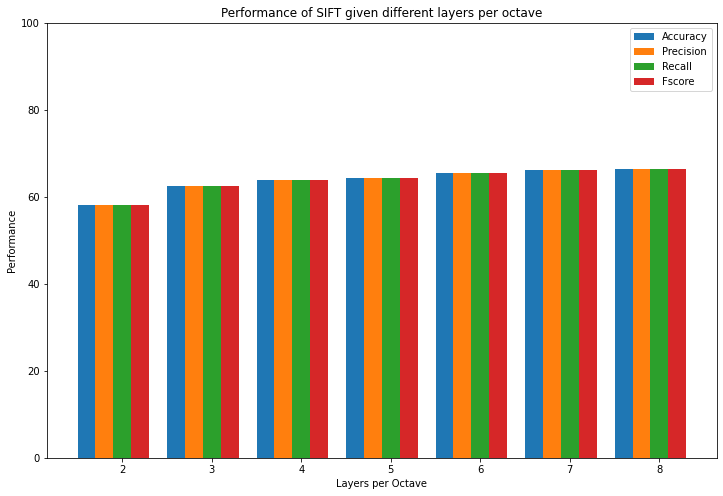

In [218]:
# Each dict in list represents an experiment
layers = []
params = []
for i in range(2, 9):
    layers.append(i)
    params.append({'method':'kmeans', 'k':260, 'detector_data':{'name':'sift', 'detector': cv2.SIFT_create(nOctaveLayers=i), 'extra':'n_octave_layers_'+str(i)},
                          'classification_method':{'name':'svm','kernel':'linear'}, 'normalization':None, 'spatial_pyramids':None, 'dimensionality_reduction':None})

experiment = Experiment(params, n_splits=2)
accuracy, precision, recall, fscore = experiment.run()

plt.figure(figsize=(12,8))
X_axis = np.arange(len(layers))
plt.bar(X_axis - 0.4, accuracy, 0.2, label='Accuracy')
plt.bar(X_axis - 0.2, precision, 0.2, label='Precision')
plt.bar(X_axis, recall, 0.2, label='Recall')
plt.bar(X_axis + 0.2, fscore, 0.2, label='Fscore')


plt.xticks(X_axis, layers)
plt.xlabel('Layers per Octave')
plt.ylabel('Performance')
plt.title('Performance of SIFT given different layers per octave')
plt.legend()
plt.ylim(0,100)
plt.show()

Increasing the number of layers per octave in SIFT increases the performance of our classification method (an SVM classifier with linear kernel). One reason for the increase in performance is because that having more layers on each octave increases the number of keypoints obtained. In the original SIFT paper by David G.Lowe the number of layers per octave used where 3.

## Effect of increasing the codebook size

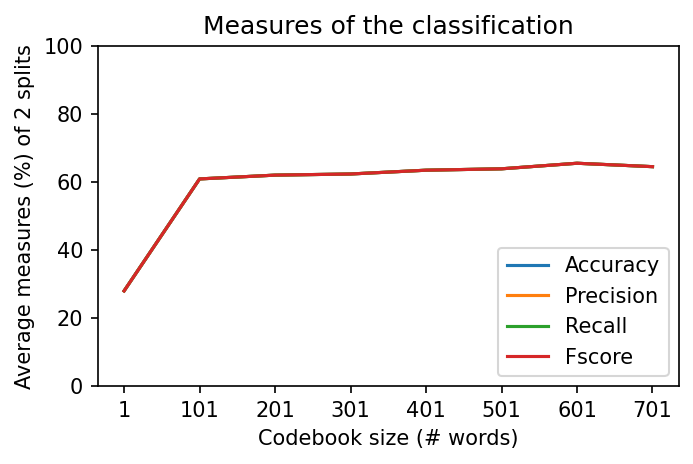

In [220]:
# Each dict in list represents an experiment
params = []
codebook_sizes = []
for i in range(1, 800, 100):
    codebook_sizes.append(i)
    params.append({'method':'kmeans', 'k':i, 'detector_data':{'name':'sift', 'detector': cv2.SIFT_create()},
                          'classification_method':{'name':'svm','kernel':'linear'}, 'normalization':None, 'spatial_pyramids':None, 'dimensionality_reduction':None})

experiment = Experiment(params, n_splits=2)
accuracy, precision, recall, fscore = experiment.run()

plt.figure(figsize=(5,3), dpi=150)
plt.plot(codebook_sizes, accuracy)
plt.plot(codebook_sizes, precision)
plt.plot(codebook_sizes, recall)
plt.plot(codebook_sizes, fscore)
plt.ylim(0,100)
plt.legend(['Accuracy', 'Precision', 'Recall', 'Fscore'])
plt.title("Measures of the classification")
plt.xlabel("Codebook size (# words)")
plt.ylabel(f"Average measures (%) of {2} splits")
plt.xticks(codebook_sizes)
plt.show()

Increasing the codebook size increases also the performance up to a point, where it remains steady (codebook size of 600). However, it's important to note that increasing the codebook size also increases the computational time required to train and classify the data. As a result, determining the codebook size frequently involves making a trade-off between performance and computational time. Obtaining these results, we decided to carry out our experiments with a codebook size = 260. 

## Effect of increasing the step size Dense SIFT

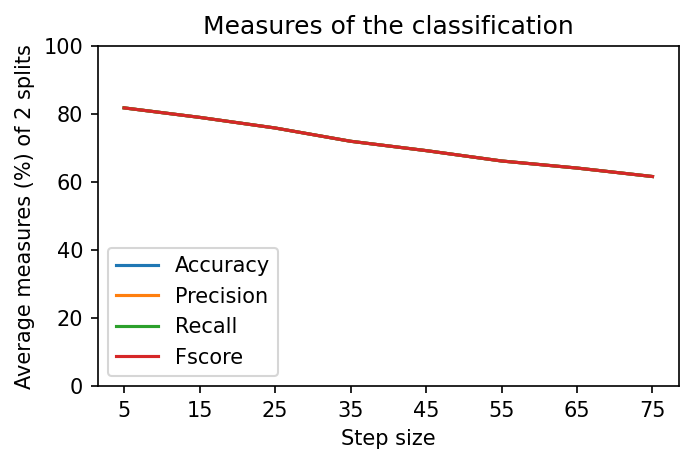

In [221]:
# Each dict in list represents an experiment
params = []
step_sizes = []

for i in range(5, 80, 10):
    step_sizes.append(i)
    params.append({'method':'kmeans', 'k':260, 'detector_data':{'name':'dense_sift', 'detector': cv2.SIFT_create(), 'step_size':i},
                          'classification_method':{'name':'svm','kernel':'linear'}, 'normalization':None, 'spatial_pyramids':None, 'dimensionality_reduction':None})

experiment = Experiment(params, n_splits=2)
accuracy, precision, recall, fscore = experiment.run()


plt.figure(figsize=(5,3), dpi=150)
plt.plot(step_sizes, accuracy)
plt.plot(step_sizes, precision)
plt.plot(step_sizes, recall)
plt.plot(step_sizes, fscore)
plt.ylim(0,100)
plt.legend(['Accuracy', 'Precision', 'Recall', 'Fscore'])
plt.title("Measures of the classification")
plt.xlabel("Step size")
plt.ylabel(f"Average measures (%) of {2} splits")
plt.xticks(step_sizes)
plt.show()

When increasing the number of steps it can be seen that it can speed up the computation of the Dense SIFT descriptor but the overall performance of the classifier decreases. That may happen because increasing the number of steps decreases the number of keypoints that need to be computed on each image and so, the available information may be lost. 

### Effect of different classifiers

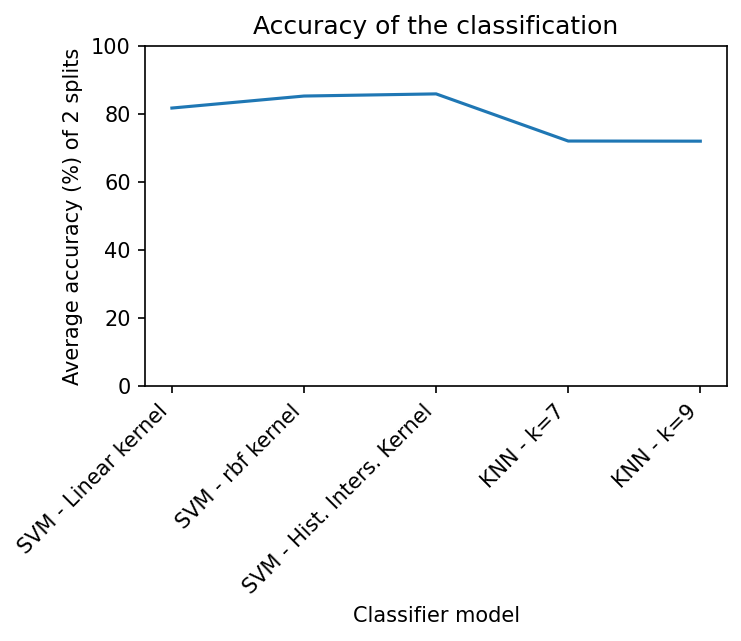

In [222]:
# Each dict in list represents an experiment
clfs_names = ["SVM - Linear kernel", "SVM - rbf kernel", "SVM - Hist. Inters. Kernel", "KNN - k=7", "KNN - k=9"]

params = [{'method':'kmeans', 'k':260, 'detector_data':{'name':'dense_sift', 'detector': cv2.SIFT_create(), 'step_size':5},
                        'classification_method':{'name':'svm','kernel':'linear'}, 'normalization':None, 'spatial_pyramids':None, 'dimensionality_reduction':None},
                {'method':'kmeans', 'k':260, 'detector_data':{'name':'dense_sift', 'detector': cv2.SIFT_create(), 'step_size':5},
                        'classification_method':{'name':'svm','kernel':'rbf'}, 'normalization':None, 'spatial_pyramids':None, 'dimensionality_reduction':None},
                {'method':'kmeans', 'k':260, 'detector_data':{'name':'dense_sift', 'detector': cv2.SIFT_create(), 'step_size':5},
                        'classification_method':{'name':'svm','kernel':'histogram_intersection'}, 'normalization':None, 'spatial_pyramids':None, 'dimensionality_reduction':None},
                {'method':'kmeans', 'k':260, 'detector_data':{'name':'dense_sift', 'detector': cv2.SIFT_create(), 'step_size':5},
                        'classification_method':{'name':'knn'}, 'n':7, 'normalization':None, 'spatial_pyramids':None, 'dimensionality_reduction':None},
                {'method':'kmeans', 'k':260, 'detector_data':{'name':'dense_sift', 'detector': cv2.SIFT_create(), 'step_size':5},
                        'classification_method':{'name':'knn'}, 'n':9, 'normalization':None, 'spatial_pyramids':None, 'dimensionality_reduction':None}]

experiment = Experiment(params, n_splits=2)
accuracy, precision, recall, fscore = experiment.run()

plt.figure(figsize=(5,3), dpi=150)
plt.plot(np.arange(len(clfs_names)), accuracy)
plt.title("Accuracy of the classification")
plt.xlabel("Classifier model")
plt.ylabel(f"Average accuracy (%) of {2} splits")
plt.xticks(np.arange(len(clfs_names)), labels=clfs_names, rotation=45, ha="right")
plt.ylim(0, 100)
plt.show()

SVM classifiers achieves a much higher accuracy overall versus KNN. That may happen because of the underlying data distribution of the dataset.

## Effect of using different spatial pyramids divisions with Dense SIFT

We've divided each image in 4 and 16 blocks to compare its perfomance taking into account the spatial information.

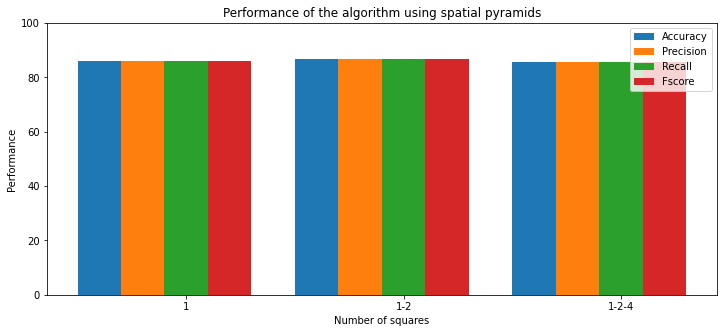

In [225]:
# Each dict in list represents an experiment

layers = ['1', '1-2', '1-2-4']

params = [{'method':'kmeans', 'k':260, 'detector_data':{'name':'dense_sift', 'detector': cv2.SIFT_create(), 'step_size':5},
                          'classification_method':{'name':'svm','kernel':'histogram_intersection'}, 'normalization':None, 
                          'spatial_pyramids':{'n_squares':[1], 'n_weights':[1/2]}, 'dimensionality_reduction':None},
          {'method':'kmeans', 'k':260, 'detector_data':{'name':'dense_sift', 'detector': cv2.SIFT_create(), 'step_size':5},
                          'classification_method':{'name':'svm','kernel':'histogram_intersection'}, 'normalization':None, 
                          'spatial_pyramids':{'n_squares':[1, 2], 'n_weights':[1/2, 1/2]}, 'dimensionality_reduction':None},
          {'method':'kmeans', 'k':260, 'detector_data':{'name':'dense_sift', 'detector': cv2.SIFT_create(), 'step_size':5},
                          'classification_method':{'name':'svm','kernel':'histogram_intersection'}, 'normalization':None, 
                          'spatial_pyramids':{'n_squares':[1, 2, 4], 'n_weights':[0.2, 0.3, 0.5]}, 'dimensionality_reduction':None}]

experiment = Experiment(params, n_splits=2)
accuracy, precision, recall, fscore = experiment.run()

plt.figure(figsize=(12,5))
X_axis = np.arange(len(layers))
plt.bar(X_axis - 0.4, accuracy, 0.2, label='Accuracy')
plt.bar(X_axis - 0.2, precision, 0.2, label='Precision')
plt.bar(X_axis, recall, 0.2, label='Recall')
plt.bar(X_axis + 0.2, fscore, 0.2, label='Fscore')


plt.xticks(X_axis, layers)
plt.xlabel('Number of squares')
plt.ylabel('Performance')
plt.title('Performance of the algorithm using spatial pyramids')
plt.legend()
plt.ylim(0,100)
plt.show()

Overall, no big difference has been found of using spatial pyramid with Dense SIFT

## Effect of using different spatial pyramids divisions with SIFT

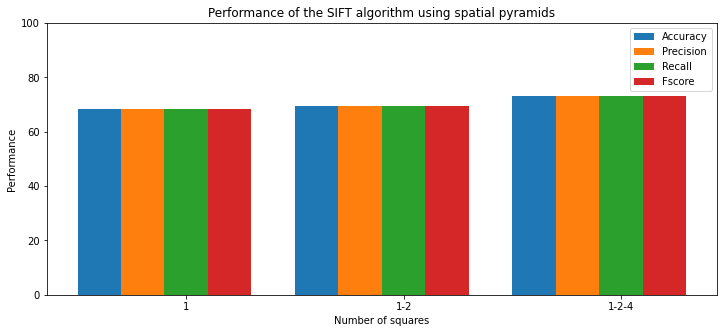

In [232]:
# Each dict in list represents an experiment

layers = ['1', '1-2', '1-2-4']

params = [{'method':'kmeans', 'k':260, 'detector_data':{'name':'sift', 'detector': cv2.SIFT_create()},
                          'classification_method':{'name':'svm','kernel':'histogram_intersection'}, 'normalization':None, 
                          'spatial_pyramids':{'n_squares':[1], 'n_weights':[1]}, 'dimensionality_reduction':None},
          {'method':'kmeans', 'k':260, 'detector_data':{'name':'sift', 'detector': cv2.SIFT_create()},
                          'classification_method':{'name':'svm','kernel':'histogram_intersection'}, 'normalization':None, 
                          'spatial_pyramids':{'n_squares':[1, 2], 'n_weights':[1/2, 1/2]}, 'dimensionality_reduction':None},
          {'method':'kmeans', 'k':260, 'detector_data':{'name':'sift', 'detector': cv2.SIFT_create()},
                          'classification_method':{'name':'svm','kernel':'histogram_intersection'}, 'normalization':None, 
                          'spatial_pyramids':{'n_squares':[1, 2, 4], 'n_weights':[0.2, 0.3, 0.5]}, 'dimensionality_reduction':None}]

experiment = Experiment(params, n_splits=2)
accuracy, precision, recall, fscore = experiment.run()

plt.figure(figsize=(12,5))
X_axis = np.arange(len(layers))
plt.bar(X_axis - 0.4, accuracy, 0.2, label='Accuracy')
plt.bar(X_axis - 0.2, precision, 0.2, label='Precision')
plt.bar(X_axis, recall, 0.2, label='Recall')
plt.bar(X_axis + 0.2, fscore, 0.2, label='Fscore')


plt.xticks(X_axis, layers)
plt.xlabel('Number of squares')
plt.ylabel('Performance')
plt.title('Performance of the SIFT algorithm using spatial pyramids')
plt.legend()
plt.ylim(0,100)
plt.show()

By contrast, using spatial pyramid with SIFT provides an increase in performance in all the metrics used. 

We conclude then that the spatial information is important to the performance in image classification. 

# Effect of normalizing feature descriptors

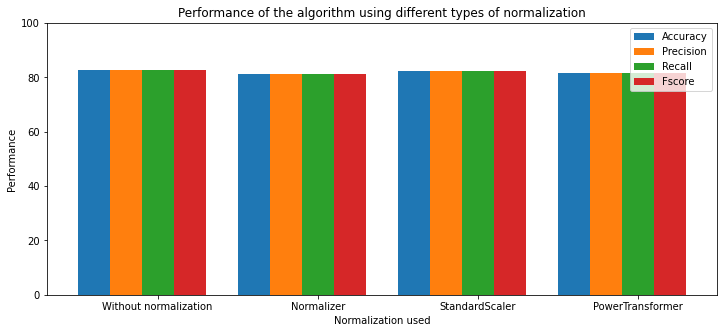

In [231]:
layers = ['Without normalization', 'Normalizer', 'StandardScaler', 'PowerTransformer']

params = [{'method':'kmeans', 'k':260, 'detector_data':{'name':'dense_sift', 'detector': cv2.SIFT_create(), 'step_size':15},
           'classification_method':{'name':'svm','kernel':'histogram_intersection'},'normalization':None, 'spatial_pyramids':None, 'dimensionality_reduction':None},
          {'method':'kmeans', 'k':260, 'detector_data':{'name':'dense_sift', 'detector': cv2.SIFT_create(), 'step_size':15},
           'classification_method':{'name':'svm','kernel':'histogram_intersection'},'normalization':'normalizer', 'spatial_pyramids':None, 'dimensionality_reduction':None},
          {'method':'kmeans', 'k':260, 'detector_data':{'name':'dense_sift', 'detector': cv2.SIFT_create(), 'step_size':15},
           'classification_method':{'name':'svm','kernel':'histogram_intersection'},'normalization':'standardscaler', 'spatial_pyramids':None, 'dimensionality_reduction':None},
          {'method':'kmeans', 'k':260, 'detector_data':{'name':'dense_sift', 'detector': cv2.SIFT_create(), 'step_size':15},
           'classification_method':{'name':'svm','kernel':'histogram_intersection'},'normalization':'powertransformer', 'spatial_pyramids':None, 'dimensionality_reduction':None}]

experiment = Experiment(params, n_splits=2)
accuracy, precision, recall, fscore = experiment.run()

plt.figure(figsize=(12,5))
X_axis = np.arange(len(layers))
plt.bar(X_axis - 0.4, accuracy, 0.2, label='Accuracy')
plt.bar(X_axis - 0.2, precision, 0.2, label='Precision')
plt.bar(X_axis, recall, 0.2, label='Recall')
plt.bar(X_axis + 0.2, fscore, 0.2, label='Fscore')


plt.xticks(X_axis, layers)
plt.xlabel('Normalization used')
plt.ylabel('Performance')
plt.title('Performance of the algorithm using different types of normalization')
plt.legend()
plt.ylim(0,100)
plt.show()

Overall no big difference in performance is found between the different normalizations used on the descriptors. However, it is better to normalize features before training a model. This way, we ensure that the algorithm doesn't give more weight to certain features and so, they contribute equally to the distance measure.

## Visualizing results (initial, intermediate and final)

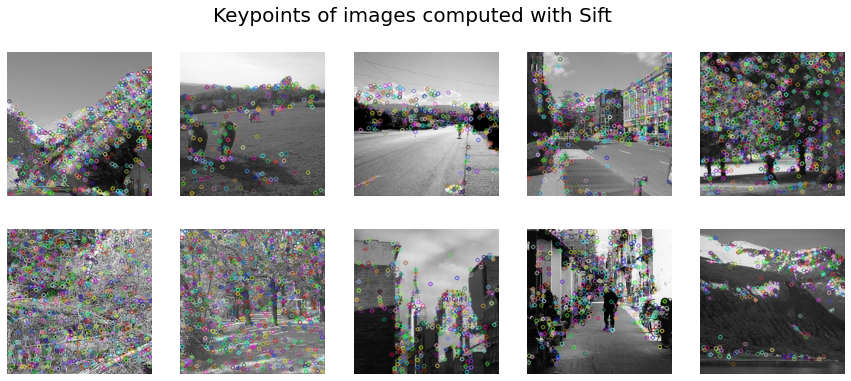

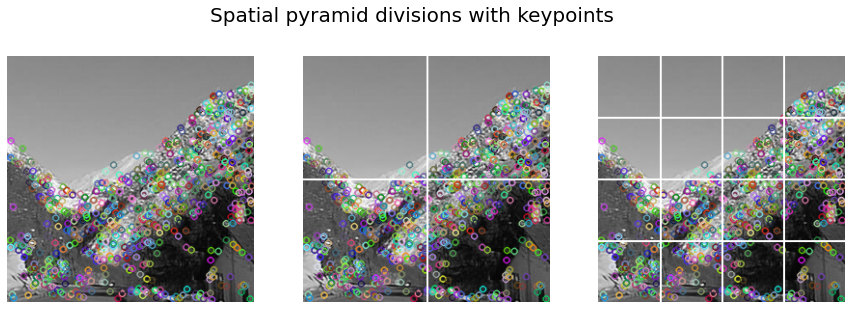

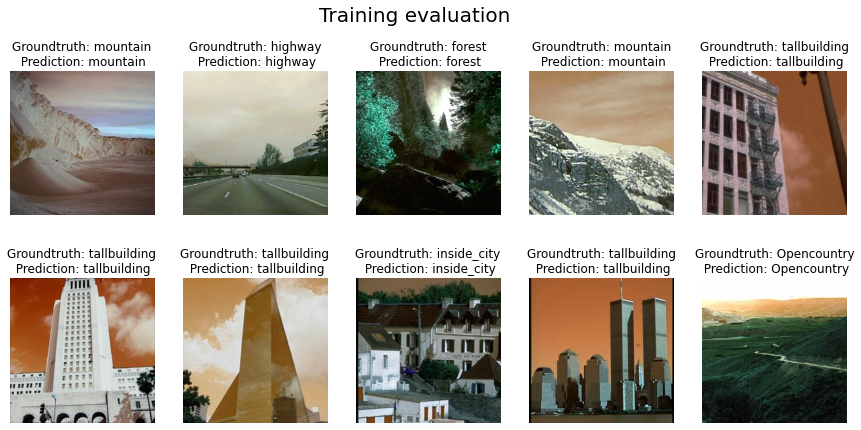

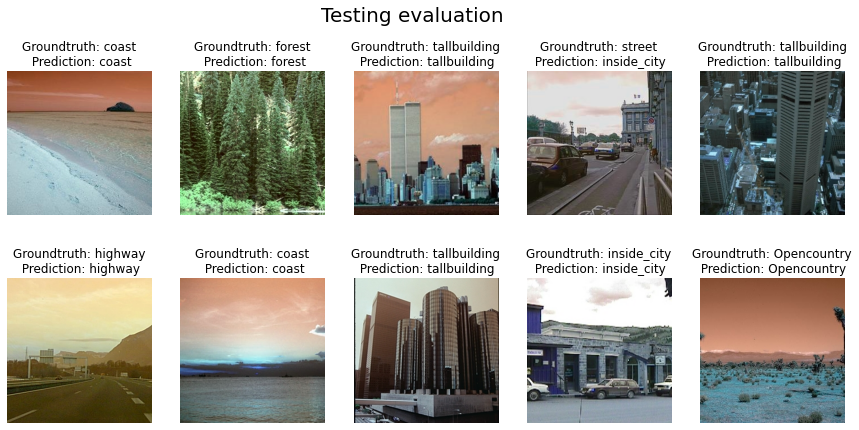

<Figure size 432x288 with 0 Axes>

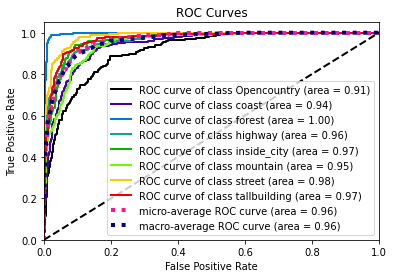

SystemExit: 

In [203]:
params = [{'method':'kmeans', 'k':260, 'detector_data':{'name':'sift', 'detector': cv2.SIFT_create()},
                          'classification_method':{'name':'svm','kernel':'histogram_intersection'}, 'normalization':None, 
                          'spatial_pyramids':{'n_squares':[1,2,4], 'n_weights':[0.2, 0.3, 0.5]}, 'dimensionality_reduction':None, 'visualization':True}]

experiment = Experiment(params, n_splits=2, for_visualization=True)
accuracy, precision, recall, fscore = experiment.run()

On our BoVW class we have implemented a visualization method that allows us to see the initial, intermediate and final steps of the algorithm.

Additionally, we can plot the Receiver Operating Characteristic (ROC) Curves of the final classifier which allows us to see the trade-off between sensitivity and specifity of our model in a dataset. We can observe that the class Forest is the best classified, as we saw the previous week, and the worst classified is Opencountry. This makes sense if we consider our dataset. 

# Conclusion

In this work we have compared different classification algorithms such as SVM and KNN and we have improved over our previous analysis providing more insights into the performance of our algorithms given different parameters. As a special mention, increasing the number of layers per octave on the SIFT feature detector increases the performance of the algorithm. Also, SVM is by a large amount of performance metrics a better classifier in this dataset. The different normalization methods did not give any special difference in performance, perhaps because of the algorithms used, that are more or less robust to the distribution of the input data. Additionaly, spatial pyramid has been implemented giving a substantial increase in accuracy.

To conclude, we have implemented multiple python classes that allow us to perform different experiments on a dataset in an easy way and that allow the visualization and analysis of the used algorithms.